In [119]:
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import inflect       

In [120]:
df = pd.read_excel('preprocessed_text.xlsx', names=['serial', 'Text', 'from','to'])

In [121]:
df.drop(['serial'], axis = 1, inplace = True)

In [122]:
df.head()

,Text,from,to
0,if you cannot read this email please click he...,webmaster@earnings.com,pallen@enron.com
1,image image dear phillip congratulations ...,discount@open2win.oi3.net,pallen@enron.com
2,earlier this week enron global technology ann...,Enron Announcements/Corp/Enron@ENRON on behalf...,All Enron Worldwide@ENRON
3,d steffes enron com sue nord enron com l nic...,ray.alvarez@enron.com,"j..kean@enron.com, richard.shapiro@enron.com, ..."
4,suzanne calcagno enron com mark courtney enro...,w..cantrell@enron.com,"leslie.lawner@enron.com, k..allen@enron.com, d..."


In [123]:
df.shape

(61752, 3)

As the dataset is huge considering only the 5000 records due to pc configuration limitations

In [160]:
new_df = df.sample(5000)

In [161]:
new_df = new_df.reset_index(drop=True)
new_df.head()

,Text,from,to
0,bruce attached is the information for the pro...,gerald.nemec@enron.com,jzively@earthlink.net
1,agreements for our japanese affiliate sarasar...,Sara Shackleton on 08/17/2000 11,Darren Delage/HOU/ECT@ECT
2,fyiam helloiroquois 5th annual customer golf...,chris.germany@enron.com,undisclosed-recipients
3,rick buyfrank hayden503 464 2663 thank you cri...,cristal.metz@enron.com,Rod Hayslett
4,mark haedicke just got back today i m sure he...,Tana Jones@ECT on 01/24/2001 03,Carol St Clair/HOU/ECT@ECT


In [162]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#on first run came across this words in cluster so appending them in stopwords
eng_stopwords = stopwords.words('english')
eng_stopwords.extend(['thanks','please','need','attached','com','would','like','also','know'])
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in eng_stopwords:
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return lemmas

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [163]:
#preprocessing the text by removing the punctuations, removing the numbers, lemmatising the verbs and removing stopwords
def preprocess(text):
    text = re.sub('[^a-zA-z]+',' ', text) #removing numbers
    content = nltk.word_tokenize(text)
    words = to_lowercase(content)
    words = lemmatize_verbs(words)#lemmatising verbs
    words = remove_punctuation(content)
    words = remove_stopwords(words)
    text = ' '.join(words)
    return text

In [164]:
new_df['Text'] = new_df['Text'].apply(preprocess)

In [165]:
new_df.head()

,Text,from,to
0,bruce information property settlement sorry it...,gerald.nemec@enron.com,jzively@earthlink.net
1,agreements japanese affiliate sarasara shackle...,Sara Shackleton on 08/17/2000 11,Darren Delage/HOU/ECT@ECT
2,fyiam helloiroquois th annual customer golf to...,chris.germany@enron.com,undisclosed-recipients
3,rick buyfrank hayden thank cristal metzexecuti...,cristal.metz@enron.com,Rod Hayslett
4,mark haedicke got back today sure putting fire...,Tana Jones@ECT on 01/24/2001 03,Carol St Clair/HOU/ECT@ECT


Considering the word length greater than 3, ignoring the terms which appears in more than 60% and appearing less than 4 documents.
Initially tried with max_df=0.5 and min_df = 2 results were not that interesting

In [166]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{4,}', max_df= 0.6, min_df=4)

In [167]:
X = tfidf_vect.fit_transform(new_df.Text)

In [168]:
X.shape

(5000, 9980)

In [169]:
features = tfidf_vect.get_feature_names()

In [170]:
#dimensionality reduction using PCA technique
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

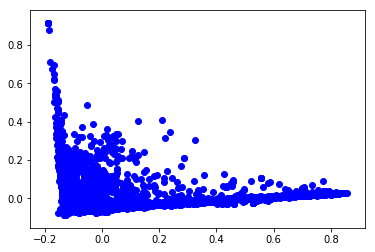

In [171]:
plt.scatter(coords[:, 0], coords[:, 1], c='b')
plt.show()

# Silhouette Analysis
#### To identify the optimal number of clusters

In [172]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k).fit(X)
    sse_.append([k, silhouette_score(X, kmeans.labels_)])

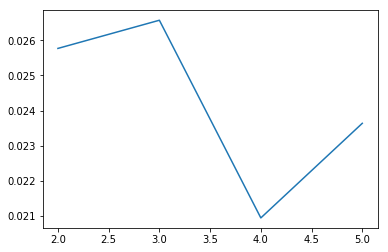

In [173]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

Based on the silhouettee anlaysis I have decided 3 as the number of clusters

In [174]:
N = 3
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
prediction = clf.fit_predict(X)

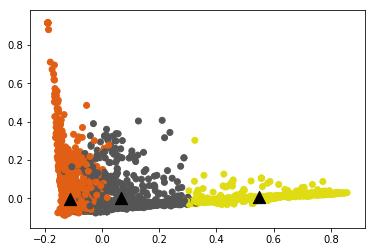

In [175]:
label = ["#e05f14", "#e0dc14", "#555555"]
color = [label[i] for i in prediction]
plt.scatter(coords[:, 0], coords[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

Top keywords in each cluster

In [176]:
#top terms per cluster
order_centroids = clf.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names()
for i in range(N):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind]),
    

Cluster 0:
 message
 original
 call
 enron
 questions
 mark
 time
 agreement
 deal
 information
 power
 think
 mail
 sent
 blackberry
Cluster 1:
 enron
 john
 mark
 michael
 enronxgate
 davis
 guzman
 mier
 ryan
 slinger
 solberg
 pete
 david
 anderson
 corp
Cluster 2:
 enron
 corp
 sara
 america
 north
 smith
 message
 street
 texas
 ahouston
 shackleton
 phone
 recipient
 original
 shackletonenron


In [177]:
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
import gensim

In [197]:
text_list = []
for i in new_df['Text']:
    k = i.split()
    k = [i for i in k if len(i)>3]#removing the words whose length is less than 3 to compare the results with clustering
    text_list.append(k)

In [198]:
dictionary = corpora.Dictionary(text_list)
text_term_matrix = [dictionary.doc2bow(text) for text in text_list]

In [199]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=3, id2word = dictionary, passes=30)

In [200]:
print(ldamodel.print_topics(num_topics=3, num_words=15))

[(0, '0.004*"market" + 0.004*"time" + 0.003*"image" + 0.003*"company" + 0.003*"said" + 0.003*"energy" + 0.003*"year" + 0.003*"business" + 0.003*"information" + 0.003*"trading" + 0.002*"power" + 0.002*"week" + 0.002*"last" + 0.002*"message" + 0.002*"back"'), (1, '0.015*"enron" + 0.015*"message" + 0.012*"original" + 0.006*"corp" + 0.005*"agreement" + 0.005*"sara" + 0.004*"call" + 0.004*"deal" + 0.004*"contract" + 0.004*"mail" + 0.004*"information" + 0.003*"review" + 0.003*"email" + 0.003*"questions" + 0.003*"credit"'), (2, '0.235*"enron" + 0.009*"font" + 0.007*"john" + 0.006*"mark" + 0.005*"corp" + 0.004*"david" + 0.004*"enronxgate" + 0.003*"michael" + 0.003*"robert" + 0.003*"face" + 0.003*"size" + 0.003*"arial" + 0.003*"width" + 0.003*"mike" + 0.003*"scott"')]


Comparing the terms appeared in clustering and topic modelling, from the results it is clear that topic modelling is producing interesting results where we can see that first topic we see few terms were quite similar as in clustering but here we can say these words are related to a common topic ie realted to some energy market and the business related to it, this is evident clearly in topic modelling than the clustering